In [1]:
import os
import pdb 
import time
import logging
import mxnet as mx
import numpy as np
from os.path import join
from mxnet.gluon import nn
import matplotlib.pyplot as plt
from mxnet import gluon, nd, autograd
from mxnet.gluon.nn import Conv2D, LeakyReLU, BatchNorm, Dropout, Activation, Conv2DTranspose
from datetime import datetime
%matplotlib inline

### Step 0: Data Preprocessing  
* 这里使用和上一节类似的`os.walk + mx.io.NDArrayIter`的套路

In [2]:
Dataset_Path= 'CMP_Dataset/facades/'

In [3]:
img_wd, img_ht = 256, 256
def preprocess_single_img(img):
    assert isinstance(img, mx.ndarray.ndarray.NDArray), "input must be NDArray type."
    img = mx.image.imresize(img, 2 * img_wd, img_ht)
    img_in = img[:,:img_wd].transpose((2,0,1)).expand_dims(0)
    img_out = img[:,img_wd:].transpose((2,0,1)).expand_dims(0)
    assert img_in.shape==(1, 3, 256, 256), "image shape not correct."
    return img_in, img_out
    
def load_data(data_path, batch_size, reverse=False):
    img_in_list, img_out_list = [], []
    for path, _, files in os.walk(data_path):
        for file in files:
            if not file[-4:] in ['.jpg']:
                continue
            img_arr = mx.image.imread(join(path, file)).astype(np.float32)/127.5 - 1
            img_in, img_out = preprocess_single_img(img_arr)
            if not reverse:
                img_in_list.append(img_in)
                img_out_list.append(img_out)
            else:
                img_in_list.append(img_out)
                img_out_list.append(img_in)
    return mx.io.NDArrayIter(data = [nd.concatenate(img_in_list), nd.concatenate(img_out_list)], batch_size=batch_size)

In [4]:
iter_t = load_data(Dataset_Path+'/train', 64,True)
batch_t = iter_t.next()

* Show some samples

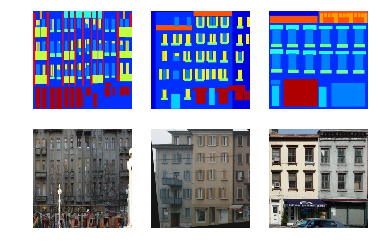

In [5]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')
def show_samples(data_iter, num_samples=4):
    img_in_list, img_out_list = data_iter.next().data
    for i in range(num_samples):
        plt.subplot(2, num_samples, i+1)
        visualize(img_in_list[i])
        plt.subplot(2, num_samples, i+num_samples+1)
        visualize(img_out_list[i])
    plt.show()
show_samples(iter_t,3)

### Step 2 Network Design  
#### 2.1 Unet网络块定义：  
注意：
①同TensorFlow一样，卷积层默认: use_bias=True  
②Unet Block定义的基本思路：先定义好Encoder-Decoder结构，最后再hybrid_forward中将Encoder-Decoder输入特征级联到输出特征即可  
③**除了最内层的Block，其他所有层，输入Encoder的feature map的通道数都是输入Decoder的feature map通道数的一半**  
④BatchNorm层默认参数设置momentum为0.9，而G和D中都设置为0.1？

In [6]:
class UnetSkipUnit(nn.HybridBlock):
    def __init__(self, inner_channels, outer_channels, inner_block=None, innermost=False, outermost=False, use_dropout=False, use_bias=False):
        super(UnetSkipUnit, self).__init__()
        # 先定义一些基本的组件
        self.outermost = outermost
        en_conv = Conv2D(channels=inner_channels, kernel_size=4, strides=2, padding=1, in_channels=outer_channels, use_bias=use_bias)
        en_relu = LeakyReLU(alpha=0.2)
        en_bn = BatchNorm(momentum=0.1, in_channels=inner_channels)
        deconv_innermost = Conv2DTranspose(
            channels=outer_channels, kernel_size=4, strides=2, padding=1, in_channels=inner_channels, use_bias=use_bias)
        deconv_output = Conv2DTranspose(
            channels=outer_channels, kernel_size=4, strides=2, padding=1, in_channels=2*inner_channels, use_bias=True)
        deconv_common = de_conv_innermost = Conv2DTranspose(
            channels=outer_channels, kernel_size=4, strides=2, padding=1, in_channels=2*inner_channels, use_bias=use_bias)

        de_relu = Activation('relu')
        de_bn = BatchNorm(momentum=0.1, in_channels=outer_channels)
        # Unet网络块可以分为三种：最里面的，中间的，最外面的。
        if innermost:
            encoder = [en_relu, en_conv]
            decoder = [de_relu, deconv_innermost, de_bn]
            model = encoder + decoder
        elif outermost:
            encoder = [en_conv]
            decoder = [de_relu, deconv_output]
            model = encoder + [inner_block] + decoder
            model += [Activation('tanh')]
        else:
            encoder = [en_relu, en_conv, en_bn]
            decoder = [de_relu, deconv_common, de_bn]
            model = encoder + [inner_block] + decoder
        if use_dropout:
            model += [Dropout(0.5)]
        self.model = nn.HybridSequential()
        with self.model.name_scope():
            for block in model:
                self.model.add(block)
    def hybrid_forward(self, F, x):
        # 除了outermost之外的block都要加skip connection
        if self.outermost:
            return self.model(x)
        else:
            #pdb.set_trace()
            return F.concat(self.model(x), x, dim=1)

In [3]:
#### Regular Check
input_channels = 3
ngf = 64

test_net = UnetSkipUnit(8 * ngf, 8 * ngf, innermost=True)


In [4]:
test_net

UnetSkipUnit(
  (model): HybridSequential(
    (0): LeakyReLU(0.2)
    (1): Conv2D(512 -> 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): Activation(relu)
    (3): Conv2DTranspose(512 -> 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm(fix_gamma=False, axis=1, momentum=0.1, use_global_stats=False, eps=1e-05, in_channels=512)
  )
)

### 2.2 Define Generator net  
注意：  
① Unet中的num_downs决定了整个网络由多少对UnetBlock组成。除了innermost，outermost以及必备的上下采样块，多出来的块将被放在中间，同innermost一起保持维度。并在这些中间块中使用dropout

In [7]:
class UnetGenerator(nn.HybridBlock):
    def __init__(self, input_channels, num_downs, ngf=64, use_dropout=True):
        super(UnetGenerator, self).__init__()
        unet= UnetSkipUnit(ngf * 8, ngf * 8, innermost=True)
        for _ in range(num_downs - 5):
            unet = UnetSkipUnit(ngf * 8, ngf * 8, unet, use_dropout=use_dropout)
        unet = UnetSkipUnit(ngf * 8, ngf * 4, unet)
        unet = UnetSkipUnit(ngf * 4, ngf * 2, unet)
        unet = UnetSkipUnit(ngf * 2, ngf * 1, unet)
        unet = UnetSkipUnit(ngf, input_channels, unet, outermost=True)
        self.model = unet
    def hybrid_forward(self, F, x):
        return self.model(x)

In [6]:
#### Regular Check:
unet = UnetGenerator(input_channels=3, num_downs=8)
unet.initialize(mx.init.Xavier())
test_input = nd.random.normal(shape=(4, 3, 256, 256))
unet.hybridize()
out = unet(test_input)
## export Gluon model to symbol .json file,then we can load as Symbol which can be graphvized. 
unet.export('GluonUnet')

* 注意：这里如果给plot_network传入data shape参数，可以在绘制的graph（保存为pdf形式）中显示出各层输出feature map的空间维度

In [11]:
unet_symbol = mx.symbol.load('GluonUnet-symbol.json')
digraph  = mx.viz.plot_network(unet_symbol, shape={'data':(4,3,256,256)}, title='pixel2pixel_G_Net')
digraph.view()

'pixel2pixel_G_Net.gv.pdf'

### 2.3 Define Discriminator Net

In [8]:
class Discriminator(nn.HybridBlock):
    def __init__(self, in_channels, n_layers=3, ndf=64, use_sigmoid=False, use_bias=False):
        super(Discriminator, self).__init__()
        # 用下面一段代码来配置标准的2x 下采样卷积
        kernel_size=4
        padding = int(np.ceil((kernel_size-1)/2))
        self.model = nn.HybridSequential()
        # 先用一个卷积将输入转为第一层feature map
        self.model.add(Conv2D(channels=ndf, kernel_size=kernel_size, strides=2, padding=padding, use_bias=use_bias, in_channels=in_channels))
        self.model.add(LeakyReLU(alpha=0.2))
        
        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            self.model.add(
                Conv2D(channels=ndf*nf_mult, kernel_size=kernel_size, strides=2, padding=padding, use_bias=use_bias, in_channels=ndf*nf_mult_prev),
                BatchNorm(momentum=0.1, in_channels=ndf*nf_mult),
                LeakyReLU(alpha=0.2))
        
        # 若layers较少，channel未达到512， 可以继续升一点维度
        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        self.model.add(
            Conv2D(channels=ndf*nf_mult, kernel_size=kernel_size, strides=1, padding=padding, use_bias=use_bias, in_channels=ndf*nf_mult_prev),
            BatchNorm(momentum=0.1, in_channels=ndf*nf_mult),
            LeakyReLU(alpha=0.2))
        # 输出： output channel为什么设为1？
        self.model.add(Conv2D(channels=1, kernel_size=kernel_size, strides=1, padding=padding, use_bias=True, in_channels=ndf*nf_mult))
        if use_sigmoid:
            self.model.add(Activation('sigmoid'))
    def hybrid_forward(self, F, x):
        return self.model(x)

In [21]:
#### Regular Check
def t(model):
    model.initialize(mx.init.Xavier())
    return model(test_input).shape
test_d = Discriminator(in_channels=6,n_layers=2)
test_d.initialize(mx.init.Xavier())

In [22]:
d_sample = nd.random_normal(shape=(4,6,256,256))
test_d(d_sample).shape

(4, 1, 67, 67)

### 2.4 Construct Network  
注意：  
①这里的loss使用binary_cross_entropy + L1 loss 作为最终的loss。L1 loss用来capture 图像中的low frequencies  
②使用自定义的初始化方式:  (这里说的初始化均为实值初始化，而不是仅仅定义初始化方式)
- 卷积层：
   - $weight$: 标准差为0.02的高斯随机初始化
   - $bias$: 全零初始化
- BN层：
   - 除了$gamma$之外，所有的bn参数（$beta, running__mean, running__var$）初始化为0； $gamma$: **均值为1**，标准差0.02的高斯随机初始化  

③这里设置的Trainer中的beta1参数是bn中的吗？bn中的beta不应该是参数而不是超参数吗？ 答：是Adam中的第一动量 $β_1$

In [13]:
#### 超参数列表  
ctx = mx.gpu(0)
lr = 0.01
batch_size = 32
beta1 = 0.5  ## beta_1（第一动量）默认设置是0.9，为什么这里差别也这么大？？？
pool_size = 50
num_epochs = 200

In [14]:
def init_param(param):
    if param.name.find('conv') != -1: # conv层的参数，包括w和b
        if param.name.find('weight') != -1:
            param.initialize(init=mx.init.Normal(0.02), ctx=ctx)
        else:
            param.initialize(init=mx.init.Zero(), ctx=ctx)
    elif param.name.find('batchnorm') != -1: #bn层的参数
        param.initialize(init=mx.init.Zero(), ctx=ctx)
        if param.name.find('gamma')!=-1:
            param.set_data(nd.random_normal(1, 0.02, param.data().shape))
def network_init(net):
    for param in net.collect_params().values():
        init_param(param)
# 正式定义网络架构
def set_networks(ckpt=None):
    netG = UnetGenerator(input_channels=3, num_downs=8)
    netD = Discriminator(in_channels=6, n_layers=3)
    
    if ckpt is not None:
        print('[+]Loading Checkpoints {} ...'.format(ckpt))
        netG.load_parameters(ckpt+'G.params', ctx=ctx)
        netD.load_parameters(ckpt+'D.params', ctx=ctx)
        print('[+]Checkpoint loaded successfully!')
    else:
        network_init(netG)
        network_init(netD)
    
    trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate':lr, 'beta1':beta1})
    trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate':lr, 'beta1':beta1})
    
    return netG, netD, trainerG, trainerD

###################### Set loss function #######################
GAN_loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
L1_loss = gluon.loss.L1Loss()

In [15]:
#### Regular Check
netG, netD, trainerG, trainerD = set_networks()

## Step 3: Training Loop

### 3.1 为判别模型专门定义一个ImagePool，使得判别模型不仅仅比较当前的真实输入和虚假输出的损失，还要考虑历史损失  
* 理解：  

首先在pool满之前，读入的每张图像都会被存储在pool的images成员变量中。同时也会返回一份给ret，用于传递到函数外面。  
pool中只能存50张images，很快就会被占满。当pool满了以后，再query一个样本时，pool可能以百分之五十的几率选择如下两种操作中的一个:  
  
①使用读入的image替换掉images列表中的随机一张，替换得到的images中的old image被分给ret，随后返回。  
②新的image被加入到ret中，pool中的images列表不更新  
* 问题：  


①ImagePool的作用是什么？  
②pool会对每张图像进行qurey操作，最起码有一些nd运算。这会对训练的迭代速度产生多大的影响？

In [16]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        ret_imgs = []
        for i in range(images.shape[0]):
            image = nd.expand_dims(images[i], axis=0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                ret_imgs.append(image)
            else:
                p = nd.random_uniform(0, 1, shape=(1,)).asscalar()
                if p > 0.5:
                    random_id = nd.random_uniform(0, self.pool_size - 1, shape=(1,)).astype(np.uint8).asscalar()
                    tmp = self.images[random_id].copy()
                    self.images[random_id] = image
                    ret_imgs.append(tmp)
                else:
                    ret_imgs.append(image)
        ret_imgs = nd.concat(*ret_imgs, dim=0)
        return ret_imgs

### Step 3.2 Training Loop

In [17]:
train_data = load_data(join(Dataset_Path,'train'), batch_size, reverse=True)
val_data = load_data(join(Dataset_Path,'val'), batch_size, reverse=True)
test_data = load_data(join(Dataset_Path,'test'), batch_size, reverse=True)

In [13]:
%matplotlib notebook

def facc(label, pred):
    return ((pred.ravel()>0.5) == (label.ravel())).mean()

def train(lamda=100, lr_decay=0.2, viz=False):
    image_pool = ImagePool(pool_size)
    metric = mx.metric.CustomMetric(facc)
    
    stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
    logging.basicConfig(level=logging.DEBUG)
    fig = plt.figure()
    for epoch in range(num_epochs):
        epoch_tic = time.time()
        btic = time.time()
        train_data.reset()
        for iter, batch in enumerate(train_data):
            real_in, real_out = batch.data[0].as_in_context(ctx), batch.data[1].as_in_context(ctx)
            fake_out = netG(real_in)
            fake_concat = image_pool.query(nd.Concat(real_in, fake_out, dim=1))
            with autograd.record():
                # Train with fake images
                output = netD(fake_concat) #?????????????????? 这里把x和fake一同送入D，是Conditional GAN的体现？如何理解这里的条件概率？
                fake_label = nd.zeros(output.shape, ctx=ctx)
                errD_fake = GAN_loss(output, fake_label)
                metric.update([fake_label,],[output,])  ## metric应该何时update？？？
                
                # Train with real images
                real_concat = image_pool.query(nd.Concat(real_in, real_out, dim=1))
                output = netD(real_concat)
                real_label = nd.ones(output.shape, ctx=ctx)
                errD_real = GAN_loss(output, real_label)
                errD = (errD_fake + errD_real) * 0.5 ## 如论文所述，D loss乘以0.5以降低相对G的更新速率
                errD.backward()
                metric.update([real_label,],[output,])
            trainerD.step(batch_size)
            
            with autograd.record():
                fake_out = netG(real_in)    # 这里的G为什么没有体现出Conditional GAN？？  ####### 重要 #######
                #fake_concat = image_pool.query(nd.Concat(real_in, fake_out, dim=1))
                # 注意：image_pool只用于记录判别器
                fake_concat = nd.Concat(real_in, fake_out)  # Conditional GAN的先验：real_in，即 x
                output = netD(fake_concat)
                errG = GAN_loss(output, real_label) + lamda * L1_loss(real_out, fake_out)
                errG.backward()
            trainerG.step(batch_size)
            
            if iter % 10 == 0:
                name, acc = metric.get()
                logging.info('Epoch {}, lr {:.4f}, D loss: {:3f}, G loss：{:3f}, binary training acc: {:2f}, at iter {}, Speed: {} samples/s'.format(
                epoch, trainerD.learning_rate,  errD.mean().asscalar(), errG.mean().asscalar(), acc, iter, 0.1*batch_size/ (time.time()-btic)))
            btic = time.time()
        if epoch % 10 == 0:
            trainerD.set_learning_rate(trainerD.learning_rate * lr_decay)
            trainerG.set_learning_rate(trainerG.learning_rate * lr_decay)
        name, epoch_acc = metric.get()
        metric.reset()
        logging.info('\n[+]binary training accuracy at epoch %d %s=%f' % (epoch, name, epoch_acc))
        logging.info('[+]time: {:3f}'.format(time.time() - epoch_tic))
        plt.clf()
        fake_img = fake_out[0]
        #pdb.set_trace()
        visualize(fake_img)
        fig.canvas.draw()

<IPython.core.display.Javascript object>


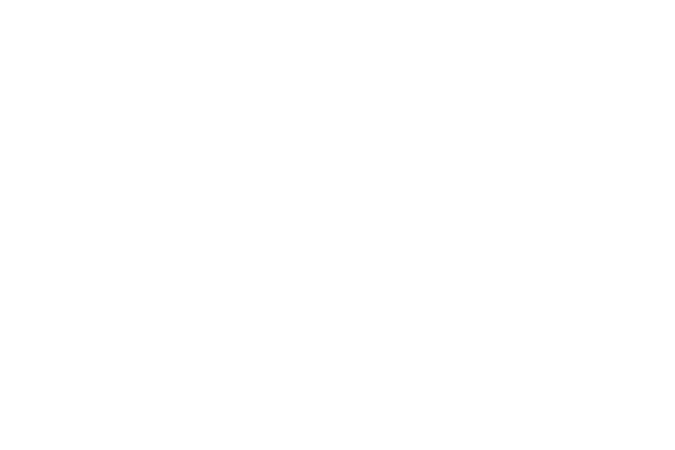

INFO:root:Epoch 0, lr 0.0100, D loss: 0.738721, G loss：32.977802, binary training acc: 0.427360, at iter 0, Speed: 1.9266846610365718 samples/s
INFO:root:Epoch 0, lr 0.0100, D loss: 0.773014, G loss：22.000574, binary training acc: 0.500931, at iter 10, Speed: 3.4521801933788625 samples/s
INFO:root:
[+]binary training accuracy at epoch 0 facc=0.501015
INFO:root:[+]time: 8.034370
INFO:root:Epoch 1, lr 0.0020, D loss: 0.747430, G loss：20.120523, binary training acc: 0.505064, at iter 0, Speed: 4.915383006813609 samples/s
INFO:root:Epoch 1, lr 0.0020, D loss: 0.658469, G loss：15.074265, binary training acc: 0.506277, at iter 10, Speed: 3.400087194890714 samples/s
INFO:root:
[+]binary training accuracy at epoch 1 facc=0.505802
INFO:root:[+]time: 7.024787
INFO:root:Epoch 2, lr 0.0020, D loss: 0.681003, G loss：14.624359, binary training acc: 0.500804, at iter 0, Speed: 4.787119996747186 samples/s
INFO:root:Epoch 2, lr 0.0020, D loss: 0.679241, G loss：14.727216, binary training acc: 0.510441, 

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


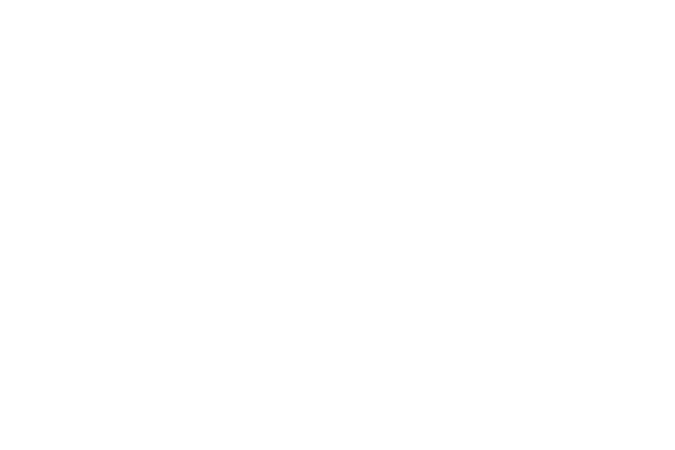

In [74]:
train(lamda=100, viz=True)

In [ ]:
netG.save_parameters('pixel_netG.params')
netD.save_parameters('pixel_netD.params')

## Evaluation

In [21]:
# netG.load_parameters('pix2pix/models/11_18/pixel_netG_11_18.params')
# netD.load_parameters('pix2pix/models/11_18/pixel_netD_11_18.params')
netG.load_parameters('pix2pix/models/11_18/pixel_netG_epoch_50.params')
netG.load_parameters('pix2pix/models/11_18/pixel_netG_epoch_50.params')

In [22]:
import random


In [23]:
def visualize_result(real_in, fake_out, real_out, num_samples=5, save=None):
    samples_idx = np.random.choice(np.arange(len(real_in)), num_samples)
    for i in range(num_samples):
        plt.subplot(3,num_samples,i+1)
        visualize(real_in[samples_idx[i]])
        plt.subplot(3,num_samples,i+1+5)
        visualize(fake_out[samples_idx[i]])
        plt.subplot(3,num_samples,i+1+10)
        visualize(real_out[samples_idx[i]])
    if save is not None:
        plt.savefig(save+'.jpg')
    else:
        plt.show()

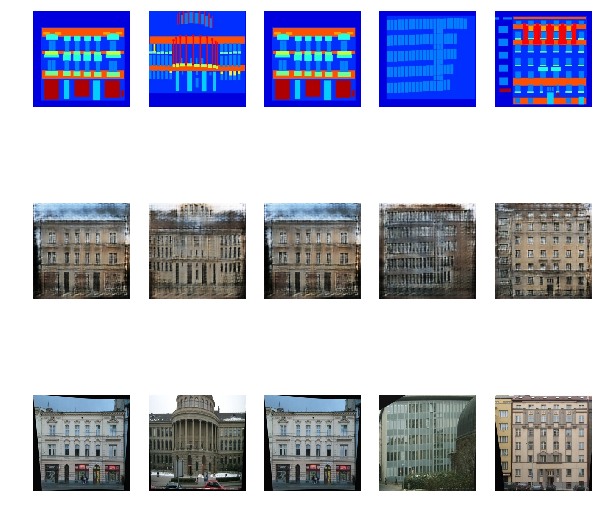

In [31]:
%matplotlib inline
fig = plt.figure(figsize=(10,10))
test_data.reset()
val_batch = test_data.next()
real_in, real_out = val_batch.data[0].as_in_context(ctx), val_batch.data[1].as_in_context(ctx)
fake_out = netG(real_in)
visualize_result(real_in, fake_out, real_out, num_samples=5) #, save='pix2pix/results_11_16/samples_test_4'

### 实验室

In [43]:
for path, _, files in os.walk(Dataset_Path):
        for file in files:
            if not file[-4:] == '.jpg':
                continue
            img_in = mx.image.imread(join(path, file)).astype(np.float32)/127.5 - 1
            img_out = mx.image.imread(join(path, file)[:-4]+'.png').astype(np.float32)/127.5 - 1
            break

In [9]:
im = mx.image.imread('1.jpg')

In [14]:
im = im[:, :255]

* 关于网络架构的理解

In [12]:
## 对nn.Layer对象进行[]运算：
inner_channels = 256
outer_channels = 128
e_conv = Conv2D(channels=inner_channels, kernel_size=4, strides=2, padding=1, in_channels=outer_channels)
e_relu = LeakyReLU(alpha=0.2)
norm = BatchNorm(momentum=0.1)
d_conv = Conv2DTranspose(channels=outer_channels, kernel_size=4, strides=2, padding=1, in_channels=inner_channels)
d_relu = Activation('relu')
test_encoder = [e_relu, e_conv]
test_decoder = [d_relu, d_conv, norm]
model = test_encoder + test_decoder

In [14]:
test_net = nn.HybridSequential()
with test_net.name_scope():
    for block in model:
        test_net.add(block)

In [15]:
test_net

HybridSequential(
  (0): LeakyReLU(0.2)
  (1): Conv2D(128 -> 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (2): Activation(relu)
  (3): Conv2DTranspose(128 -> 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm(eps=1e-05, axis=1, momentum=0.1, use_global_stats=False, fix_gamma=False, in_channels=None)
)

In [16]:
model + [Dropout(0.5)]

[LeakyReLU(0.2),
 Conv2D(128 -> 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
 Activation(relu),
 Conv2DTranspose(128 -> 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
 BatchNorm(eps=1e-05, axis=1, momentum=0.1, use_global_stats=False, fix_gamma=False, in_channels=None),
 Dropout(p = 0.5, axes=())]

In [41]:
en_conv = Conv2D(channels=512, kernel_size=4, strides=2, padding=1, in_channels=512)
de_conv_innermost = Conv2DTranspose(
            channels=512, kernel_size=4, strides=2, padding=1, in_channels=512)

In [42]:
net = nn.HybridSequential()
net.add(en_conv, de_conv_innermost)

In [43]:
net

HybridSequential(
  (0): Conv2D(512 -> 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): Conv2DTranspose(512 -> 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

* 关于参数初始化  
#### 注意：net.collect_params().values()， 即OrderedDict对象不支持直接索引，但是可以迭代，或者通过list(ordedD)[0]索引

In [17]:
params_list = test_d.collect_params().values() 

In [12]:
for param in params_list:  # 一般只要可以迭代的对象都能通过list获取，进而索引
    break

In [13]:
print(type(params_list))
print(param,'\n')
print(param.name.find('con'))
print(param.name.find('weight'))  #可见param.name.find('xx')函数可以返回某字符串在当前param对象中出现的位置

<class 'odict_values'>
Parameter conv36_weight (shape=(64, 3, 4, 4), dtype=<class 'numpy.float32'>) 

0
7


In [15]:
list(params_list)[:5]

[Parameter conv36_weight (shape=(64, 3, 4, 4), dtype=<class 'numpy.float32'>),
 Parameter conv37_weight (shape=(128, 64, 4, 4), dtype=<class 'numpy.float32'>),
 Parameter batchnorm18_gamma (shape=(128,), dtype=<class 'numpy.float32'>),
 Parameter batchnorm18_beta (shape=(128,), dtype=<class 'numpy.float32'>),
 Parameter batchnorm18_running_mean (shape=(128,), dtype=<class 'numpy.float32'>)]

In [18]:
param = list(params_list)[0]

In [20]:
param.initialize(init=mx.init.Xavier())
param.data()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Parameter 'conv43_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  """Entry point for launching an IPython kernel.



[[[[ 5.72852194e-02 -5.24133444e-02 -2.02668458e-03 -7.11383373e-02]
   [ 6.58781826e-02  1.61703303e-02 -4.72319163e-02  2.86138207e-02]
   [ 2.84756869e-02  7.17312694e-02 -1.69090852e-02  6.14653230e-02]
   [ 6.41536415e-02  4.84180450e-03 -6.23287261e-03 -2.63072699e-02]]

  [[ 4.78467271e-02 -6.15537055e-02  5.50025553e-02  2.21257508e-02]
   [-1.62445754e-02 -5.83033524e-02 -4.39049229e-02 -1.04382634e-04]
   [ 4.19147611e-02 -2.45152786e-02  1.54645815e-02 -2.51908898e-02]
   [ 5.72908074e-02  7.33079165e-02 -5.95655218e-02  5.32681048e-02]]

  [[-5.49565330e-02 -6.15021214e-02  3.25860828e-02  5.29907942e-02]
   [ 5.97130209e-02  5.75414151e-02 -5.09802997e-03  6.41570538e-02]
   [ 6.13351166e-02 -5.74157685e-02  6.64353073e-02  5.10545820e-03]
   [-4.32267748e-02  2.05045640e-02  6.19871169e-03  2.80741379e-02]]]


 [[[ 3.40468585e-02  3.66262272e-02  2.71570086e-02 -2.53383480e-02]
   [ 2.86557153e-02 -3.22777703e-02 -1.64322332e-02 -7.38486648e-03]
   [-1.55801289e-02  2.16

In [14]:
param.set_data(nd.random_normal(666, 0.02, shape=param.data().shape))
param.data()


[[[[665.9854  665.97845 666.00995 665.9687 ]
   [665.98755 665.9913  666.0218  665.99805]
   [665.9982  665.983   665.99725 666.0051 ]
   [665.9867  666.0224  666.01855 665.98535]]

  [[666.01526 665.9844  666.02386 666.0088 ]
   [666.01447 666.0246  665.9943  665.99536]
   [665.9849  666.034   665.99634 665.9963 ]
   [665.987   666.0086  665.992   665.9766 ]]

  [[665.999   666.0026  666.00275 666.0103 ]
   [665.9933  666.03375 665.96747 665.99023]
   [666.0089  665.95404 666.0318  665.9869 ]
   [665.9784  666.0043  666.0183  666.0244 ]]]


 [[[665.98956 666.0306  666.0028  666.0114 ]
   [666.0015  666.00836 666.0146  665.9947 ]
   [665.9936  665.9892  665.9937  665.9937 ]
   [666.03687 665.9989  666.0074  666.0133 ]]

  [[665.97815 666.0407  665.9619  666.0381 ]
   [666.0089  666.0188  666.02954 666.0204 ]
   [665.991   665.99506 665.9754  665.9956 ]
   [665.98047 666.0078  665.9894  665.9944 ]]

  [[666.01215 666.004   665.9757  665.9748 ]
   [666.01306 666.03107 666.0161  666.0132

In [21]:
gluon.Trainer??

* 关于ImagePool

In [31]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        ret_imgs = []
        for i in range(images.shape[0]):
            image = nd.expand_dims(images[i], axis=0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                ret_imgs.append(image)
            else:
                p = nd.random_uniform(0, 1, shape=(1,)).asscalar()
                if p > 0.5:
                    random_id = nd.random_uniform(0, self.pool_size - 1, shape=(1,)).astype(np.uint8).asscalar()
                    tmp = self.images[random_id].copy()
                    self.images[random_id] = image
                    ret_imgs.append(tmp)
                else:
                    ret_imgs.append(image)
        ret_imgs = nd.concat(*ret_imgs, dim=0)
        return ret_imgs

In [52]:
image_pool = ImagePool(pool_size=50)

In [55]:
test_batch = nd.random.normal(shape=(100,3,256, 256))
ret_imgs = image_pool.query(test_batch)

In [56]:
(ret_imgs==test_batch).mean()


[0.56]
<NDArray 1 @cpu(0)>

In [68]:
pool_imgs = nd.Concat(*image_pool.images, dim=0)

* 关于facc函数

In [86]:
pred = np.array([[0.54,0.46],[0.7,0.3],[0.2,0.8]])
label = np.array([[0,1],[1,0],[0,1]])

In [82]:
(pred.ravel()>0.5) == (label.ravel())

array([False, False,  True,  True])

In [87]:
facc(label, pred)

0.6666666666666666

## 训练记录

1. 参数  
```
ctx = mx.gpu(0)
lr = 0.01
batch_size = 32
beta1 = 0.5  ## beta_1（第一动量）默认设置是0.9，为什么这里差别也这么大？？？
pool_size = 50
num_epochs = 200
```